# Libraries

In [6]:
import torch
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

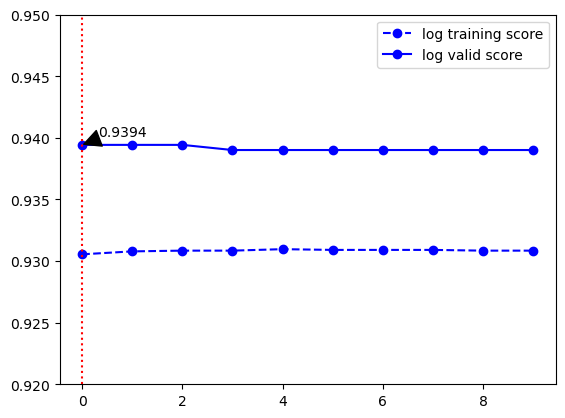

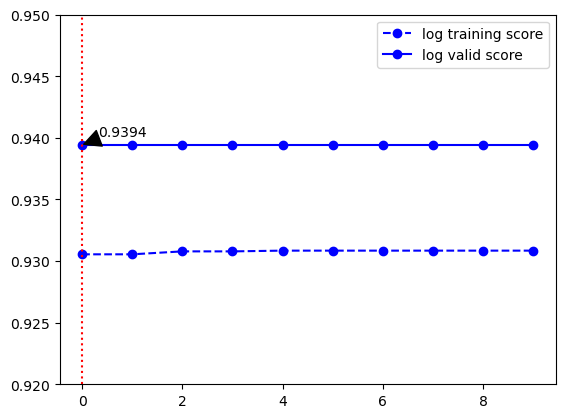

************************************************************
There are 6 set of X
X_train_selected_t1, X_train_selected_t2, X_valid_selected_t1,X_valid_selected_t2,X_test_selected_t1,X_test_selected_t2
------------------------------------------------------------
Normalized version
X_train_selected_t1_norm, X_train_selected_t2_norm, X_valid_selected_t1_norm,X_valid_selected_t2_norm,X_test_selected_t1_norm,X_test_selected_t2_norm
------------------------------------------------------------
There are 4 set of Y
y_train_t1, y_train_t2, y_valid_t1, y_valid_t2
when training, please use: 'y_train_t1_value,y_train_t2_value,y_valid_t1_value,y_valid_t2_value'
************************************************************


In [2]:
%run Data_preprocessing_realmean_final.ipynb

In [3]:

X_train_norm = X_train_selected_t1_norm
X_valid_norm = X_valid_selected_t1_norm
X_test_norm = X_test_selected_t1_norm

print(X_train_norm.shape)
print(X_valid_norm.shape)
print(X_test_norm.shape)


(16760, 52)
(2394, 52)
(4790, 52)


# Neural Network Using Sklearn build in function

In [5]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(100,), 
                   activation='relu',
                   solver='adam', 
                   alpha=0.0001, 
                   batch_size='auto', 
                   learning_rate='constant', 
                   learning_rate_init=0.01, 
                   power_t=0.5, 
                   max_iter=200, 
                   shuffle=True, 
                   random_state=None, 
                   tol=0.0001, 
                   verbose=False, 
                   warm_start=False, 
                   momentum=0.9, 
                   nesterovs_momentum=True, 
                   early_stopping=True, 
                   validation_fraction=0.1, 
                   beta_1=0.9, 
                   beta_2=0.999, 
                   epsilon=1e-08, 
                   n_iter_no_change=10, 
                   max_fun=15000)

clf.fit(X_train_norm, y_train_t2_value)

clf.score(X_valid_norm, y_valid_t2_value)

0.12321964534531882

In [6]:
y_pred = clf.predict(X_valid_norm)
rmse(y_pred, y_valid_t2_value)

NameError: name 'rmse' is not defined

# Evaluation Matrix

In [4]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Hyperparameter and setting tuning

## layers

In [ ]:
layer_list = []
rmse_lst=[]

for i in range(1,1000,20):
        layer_list.append(i)
        
for i in layer_list:
    clf = MLPRegressor(solver="adam",
                        alpha=1e-5,
                        hidden_layer_sizes=i,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(layer_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(list(range(len(layer_list))), rmse_lst, label='Layers Tuning')
plt.xlabel('Layer Choises')
plt.ylabel('RMSE')
plt.title(f"Layer {layer_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [14]:
best_layernumber = layer_list[index]
best_layernumber

(1, 1)

## Solver

['lbfgs', 'sgd', 'adam']


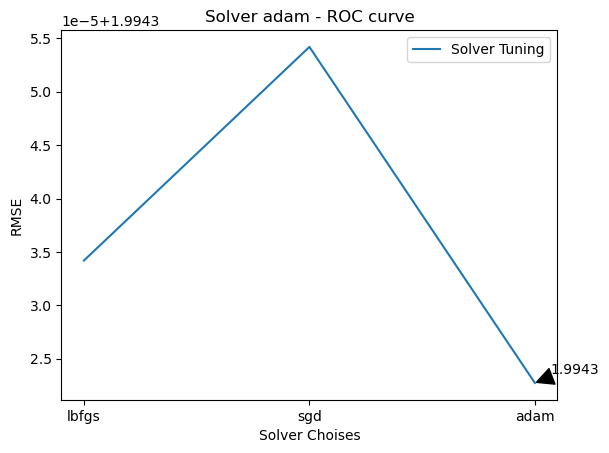

In [19]:
solver_list = ["lbfgs","sgd","adam"]
rmse_lst=[]

for i in solver_list:
    clf = MLPRegressor(solver=i,
                        alpha=1e-5,
                        hidden_layer_sizes=best_layernumber,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(solver_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(solver_list, rmse_lst, label='Solver Tuning')
plt.xlabel('Solver Choises')
plt.ylabel('RMSE')
plt.title(f"Solver {solver_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [20]:
index = np.argmin(rmse_lst)
best_solver = solver_list[index]
best_solver

'adam'

## Learning rate tuning

[1e-10, 0.0001, 0.001, 0.0032500000000000003, 0.0055000000000000005, 0.007750000000000001, 0.01, 0.01, 0.0325, 0.05500000000000001, 0.0775, 0.1, 0.1, 0.325, 0.55, 0.775, 1.0]


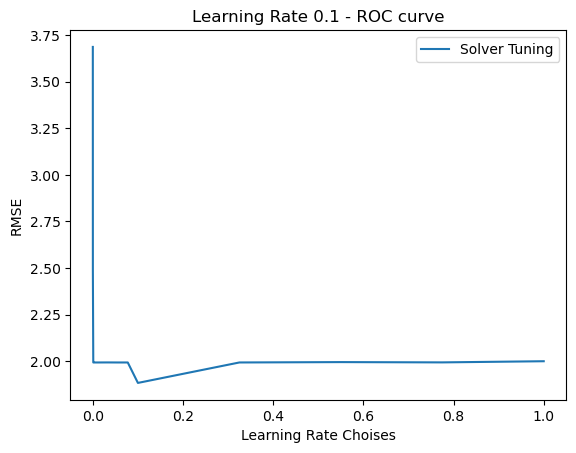

1.8847


In [29]:
lr_list = [1e-10,0.0001]+list(np.linspace(0.001,0.01,5))+list(np.linspace(0.01,0.1,5))+list(np.linspace(0.1,1,5))
rmse_lst=[]

for i in lr_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=i,
                        alpha=1e-5,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(lr_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(lr_list, rmse_lst, label='Learning Rate Tuning')
plt.xlabel('Learning Rate Choises')
plt.ylabel('RMSE')
plt.title(f"Learning Rate {lr_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()
print(np.min(rmse_lst).round(4))

In [30]:
index = np.argmin(rmse_lst)
best_lr_choice =  lr_list[index]
best_lr_choice

0.1

## Regularization strength tuning

[1e-05, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0001, 0.00011, 0.00012, 0.00013000000000000002, 0.00014000000000000001, 0.00015000000000000001, 0.00016, 0.00017, 0.00018, 0.00019, 0.0002]


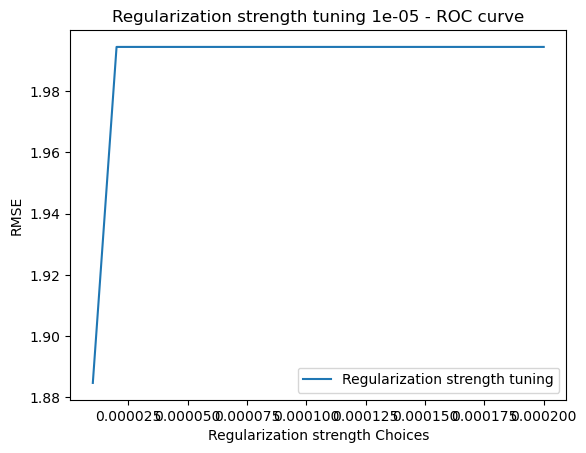

1.8847


In [41]:
reg_list = list(np.linspace(1e-5,0.00005,20))
rmse_lst=[]

for i in reg_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=best_lr_choice,
                        alpha=i,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(reg_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(list(range(len(reg_list))), rmse_lst, label='Regularization strength tuning')
plt.xlabel('Regularization strength Choices')
plt.ylabel('RMSE')
plt.title(f"Regularization strength tuning {reg_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [42]:
index = np.argmin(rmse_lst)
best_reg_choice =  reg_list[index]
best_reg_choice

1e-05

## Random State Tuning

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501, 3601]


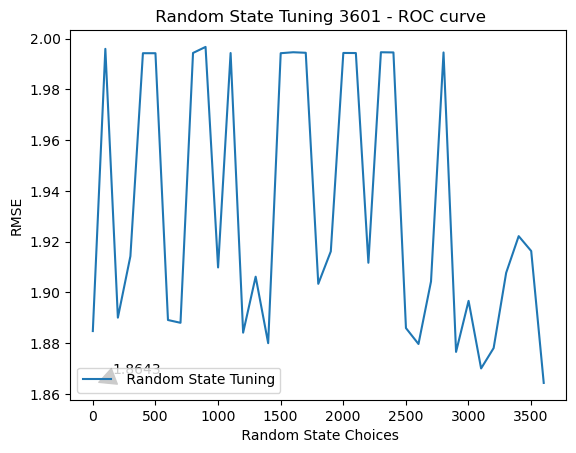

In [44]:
rs_list = list(range(1,3612,100))
rmse_lst=[]

for i in rs_list:
    clf = MLPRegressor(solver=best_solver,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate_init=best_lr_choice,
                        alpha=best_reg_choice,
                        random_state=i,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t2_value)
    y_pred = clf.predict(X_valid_norm)
    rmse1 = rmse(y_pred, y_valid_t2_value)
    rmse_lst.append(rmse1)
    
print(rs_list)
index = rmse_lst.index(min(rmse_lst))
plt.plot(rs_list, rmse_lst, label=' Random State Tuning')
plt.xlabel(' Random State Choices')
plt.ylabel('RMSE')
plt.title(f" Random State Tuning {rs_list[index]} - ROC curve")
plt.legend(loc="best")
plt.annotate(np.min(rmse_lst).round(4), (np.argmin(rmse_lst), np.min(rmse_lst)), xycoords="data",
                 xytext=(40, 20), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

# Test

In [45]:
X = np.concatenate((X_train_norm,X_valid_norm),axis=0)
y = np.concatenate((y_train_t2_value,y_valid_t2_value),axis=0)

In [67]:
# Final model
reg1 = MLPRegressor(hidden_layer_sizes=(20,1000), 
                   activation='logistic',
                   solver='adam', 
                   alpha=0.2,
                   learning_rate="adaptive", 
                   learning_rate_init=0.1, 
                   max_iter=300, 
                   shuffle=True, 
                   random_state=3612, 
                   warm_start=True, 
                   momentum=0.9, 
                   early_stopping=True, 
                   )

reg1.fit(X,y)
y_pred = reg1.predict(X_valid_norm)
rmse(y_pred, y_valid_t2_value)

1.8331037070883331

In [51]:
y_pred = reg1.predict(X_valid_norm)
rmse(y_pred, y_valid_t2_value)

1.7867877680306063

In [33]:
X_test_norm.describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,...,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4790.000000
mean,-1.483388e-18,-1.483388e-17,5.933551e-18,-5.933551e-18,4.524333e-17,-7.416939e-18,1.186710e-17,-1.112541e-17,6.675245e-18,2.225082e-18,...,-1.186710e-17,-1.186710e-17,-1.780065e-17,2.373420e-17,0.000000e+00,1.186710e-17,0.000000e+00,1.780065e-17,-2.225082e-17,0.000000
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,...,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104
min,-3.566118e-01,-4.736161e+00,-1.108402e+00,-2.510722e+00,-3.170383e-01,-1.216617e+00,-3.844358e+00,-6.382758e-01,-1.159694e+00,-2.118036e+00,...,-3.878709e+00,-5.955574e+00,-5.670569e+00,-6.841345e+00,-5.085287e+00,-5.672995e+00,-2.066637e+00,-6.447803e-01,-4.238773e+00,-1.775847
25%,-2.703750e-01,2.882147e-18,-2.711224e-01,-7.081335e-01,-2.519048e-01,5.609774e-18,-4.734616e-01,-3.767748e-01,-5.987669e-01,-2.956834e-01,...,0.000000e+00,-6.282054e-01,-7.388818e-01,-6.038237e-01,-2.038072e-02,3.454719e-17,1.042083e-17,4.188770e-17,-4.909576e-01,-0.572596
50%,0.000000e+00,2.882147e-18,0.000000e+00,-1.072709e-01,6.016953e-17,5.609774e-18,8.095031e-03,-2.477535e-17,-2.928067e-01,0.000000e+00,...,0.000000e+00,6.666879e-02,-8.132357e-02,1.837230e-02,3.604995e-17,3.454719e-17,1.042083e-17,4.188770e-17,-1.662156e-17,-0.151458
75%,0.000000e+00,2.882147e-18,0.000000e+00,4.935918e-01,6.016953e-17,5.609774e-18,4.896517e-01,-2.477535e-17,2.171270e-01,2.650404e-01,...,1.894909e-02,5.299182e-01,6.232031e-01,6.405395e-01,3.604995e-17,6.735880e-02,1.042083e-17,4.188770e-17,1.918637e-01,0.359923
max,2.745615e+01,6.030308e+00,2.847978e+01,9.806963e+00,2.865711e+01,2.340842e+01,6.268331e+00,1.814622e+01,1.041580e+01,6.075313e+01,...,6.143840e+00,7.247035e+00,3.867940e+00,3.673771e+00,6.966784e+00,4.764012e+00,2.314463e+01,1.802763e+01,8.172467e+00,23.567625


In [60]:

result = reg1.predict(X_test_norm)
res1 = pd.DataFrame(result.tolist(), columns=["Predicted"])
res1.index = X_test.index
res1.index.name = 'Id'
pd.DataFrame(res1).to_csv('out1.csv')
#print(torch.count_nonzero(torch.from_numpy(np.array(res1)).to(torch.float32)))
res1

,Predicted
Id,
32_175413_295037,4.384071
33_176176_296681,3.040878
42_119203_210828,2.364585
44_181750_291554,2.536625
61_176332_252348,2.854503
...,...
99883_150755_276467,3.100880
99897_162913_266801,2.738057
99913_175989_292375,2.488737
